<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Comparing-genes,-metabolites,-and-reactions-between-different-diatom-models" data-toc-modified-id="Comparing-genes,-metabolites,-and-reactions-between-different-diatom-models-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Comparing genes, metabolites, and reactions between different diatom models</a></span></li></ul></li><li><span><a href="#Multiple-Correspondence-Analysis" data-toc-modified-id="Multiple-Correspondence-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Multiple Correspondence Analysis</a></span><ul class="toc-item"><li><span><a href="#Reactions" data-toc-modified-id="Reactions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Reactions</a></span></li><li><span><a href="#Metabolites" data-toc-modified-id="Metabolites-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Metabolites</a></span></li><li><span><a href="#Comparing-metabolic-content" data-toc-modified-id="Comparing-metabolic-content-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Comparing metabolic content</a></span></li></ul></li><li><span><a href="#Comparing-distribution-of-rxns-among-different-pathways" data-toc-modified-id="Comparing-distribution-of-rxns-among-different-pathways-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Comparing distribution of rxns among different pathways</a></span></li><li><span><a href="#Size-of-four-diatom-genomes" data-toc-modified-id="Size-of-four-diatom-genomes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Size of four diatom genomes</a></span></li></ul></div>

In [1]:
#%matplotlib inline
import pandas as pd
import numpy as np
import xlrd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from functools import reduce
import glob
import os
import cobra
import re
from jupyterthemes import jtplot
from tqdm import tqdm
import mca
from brokenaxes import brokenaxes
pd.options.mode.chained_assignment = None
jtplot.style(theme='grade3', grid=False)

## Comparing genes, metabolites, and reactions between different diatom models

In [144]:
df_mets = pd.read_csv(os.path.join(file_path, 'proceed_all_mets.txt'), sep='\t', index_col=0)
df_rxns_no_comp = pd.read_csv(os.path.join(file_path, 'proceed_all_rxns_no_comp.txt'), sep='\t', index_col=0)

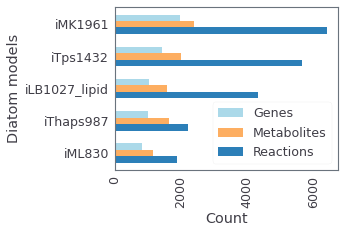

In [151]:
width = 0.2       # the width of the bars: can also be len(x) sequence
items = ['iMK_draft17','iTps1432','iLB1027_lipid','iThaps987_BiGG_original','Lavoie2020']
values_met = [len(df_mets.iMK_draft17.unique()),
            len(df_mets.iTps1432.unique()),
            len(df_mets.iLB1027_lipid.unique()), 
            #len(data.iRC1080.unique()),
            len(df_mets.iThaps987_BiGG_original.unique()),
            len(df_mets.Lavoie2020.unique())]
values_rxn = [len(df_rxns_no_comp.iMK_draft17_reactions.unique()),
           len(df_rxns_no_comp.iTps1432_reactions.unique()),
           len(df_rxns_no_comp.iLB1027_lipid_reactions.unique()),
           len(df_rxns_no_comp.iThaps987_BiGG_original.unique()),
           len(df_rxns_no_comp.Lavoie2020_reactions.unique())]
values_gene = [1961, 1432, 1027, 987, 830]
#print(values)
#change_values = [459, 316, 104]
fig, ax = plt.subplots(figsize=(4,3))

#['#ca0020','#f4a582','#bababa','#404040']
x = np.arange(len(items))  # the label locations

#['#d7191c','#fdae61','#abd9e9','#2c7bb6']
ax.barh(x-width, values_gene, width, label='Genes', color= '#abd9e9')
ax.barh(x, values_met, width, label='Metabolites', color= '#fdae61')
ax.barh(x+width, values_rxn, width, label='Reactions', color= '#2c7fb8')

#ax.barh(items, change_values, width, left=old_values,
           #label='Newly added', color= '#08519c')

ax.set_xlabel('Count')
ax.set_ylabel('Diatom models')
#ax.set_title('Comparison based on metabolites')
ax.legend()
ax.invert_yaxis()
ax.set_yticks(np.arange(5),['iMK1961', 'iTps1432', 'iLB1027_lipid',  'iThaps987',  'iML830'])
    
plt.xticks(rotation=90)
#plt.figure(figsize=(2,2))
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('main_features_bar_18.05.svg')
plt.show()

# Multiple Correspondence Analysis

## Reactions

In [2]:
# LOAD RXN DATA
df_rxns_no_comp = pd.read_csv('proceed_all_rxns_no_comp.txt', sep='\t', index_col=0)

In [3]:
## REMOVE THE IRC MODEL and iThaps987 AS IT HAS DIFFERENT REACTION IDS
rxn_col = list(df_rxns_no_comp.columns[df_rxns_no_comp.columns.str.contains('_reactions|iThaps987_BiGG_original')])
rxn_col.remove('iRC1080_reactions')
rxn_col.remove('iThaps987_BiGG_original') 
df_rxns = df_rxns_no_comp[rxn_col]

In [4]:
# TAKE A SET OF UNIQUE RXNS IN SEPARATE DATAFRAME
df_all_rxns = df_rxns.unstack().to_frame(name='rxn').reset_index(drop=True).drop_duplicates(keep='first').reset_index(drop=True)

In [5]:
## CONVERT THE RXN DATA TO BINARY DATA BY COMPARING RXNS IDS OF EACH MODEL WITH FULL LIST
for i,model in enumerate(df_rxns.columns):
    df_all_rxns[model] = df_all_rxns.rxn.isin(list(df_rxns[model]))
    df_all_rxns[model] = df_all_rxns[model].astype(int)

In [6]:
## REMOVE NANs FROM DATA
df_all_rxns[df_all_rxns.rxn.notna()].reset_index(drop=True, inplace=True)
df_all_rxns = df_all_rxns.set_index('rxn')

## Metabolites

In [7]:
# LOAD MET DATA
df_mets = pd.read_csv('proceed_all_mets.txt', sep='\t', index_col=0)

In [8]:
## REMOVE THE IRC MODEL AS IT HAS DIFFERENT MET IDS
met_col = list(df_mets.columns)
temp_list = ['iRC1080', 'iThaps987_BiGG_original','iThaps987_original','itHaps987_MetaCyc' , 'iThaps987_BiGG']
for i, item in enumerate(temp_list):
    met_col.remove(item)
df_mets = df_mets[met_col]

In [9]:
# TAKE A SET OF UNIQUE METs IN SEPARATE DATAFRAME
df_all_mets = df_mets.unstack().to_frame(name='met').reset_index(drop=True).drop_duplicates(keep='first').reset_index(drop=True)

In [10]:
## CONVERT MET DATA TO BINARY DATA BY COMPARING MET IDS OF EACH MODEL WITH FULL LIST
for i,model in enumerate(df_mets.columns):
    df_all_mets[model] = df_all_mets.met.isin(list(df_mets[model]))
    df_all_mets[model] = df_all_mets[model].astype(int)
    

In [11]:
## REMOVE THE NAN FROM DATA
df_all_mets[df_all_mets.met.notna()].reset_index(drop=True, inplace=True)
df_all_mets = df_all_mets.set_index('met')

## Comparing metabolic content

In [12]:
df_all_rxns_modif = df_all_rxns.copy()

In [13]:
df_all_mets_modif = df_all_mets.copy()

In [14]:
df_all_rxns_modif.index.name = 'items'
df_all_mets_modif.index.name = 'items'

In [15]:
df_all_rxns_modif.columns = df_all_mets_modif.columns

In [16]:
df_all_rxns_mets = pd.concat([df_all_rxns_modif, df_all_mets_modif])

In [17]:
df_all_rxns_mets.head()

,iLB1027_lipid,iMK_draft17,iTps1432,Lavoie2020
items,,,,
ATPS4m,1,0,0,0
IDP,1,1,1,1
PPAm,1,1,0,0
THD1m,1,1,0,0
ADK1,1,1,0,0


In [18]:
## TRANSPOSE DATA FOR USING AS INPUT FOR MCA
df_all_rxns_mets_T = df_all_rxns_mets.T

In [19]:
mca_counts = mca.MCA(df_all_rxns_mets_T)

In [20]:
print(mca_counts.fs_r(1)) # 1 = 100%, meaning preserve all variance.

[[ 0.02140458  0.22923401  0.08342147]
 [-0.20937838 -0.01411464 -0.11549067]
 [ 0.00544148 -0.14918545  0.121888  ]
 [ 0.55740317 -0.0291288  -0.13641769]]


In [21]:
#The eigenvalues, or principal inertias, of the factors:
print(mca_counts.L)

[0.05211411 0.01912339 0.01293539]


In [22]:
 # The inertia is simply the sum of the principle inertias:
print(mca_counts.inertia, mca_counts.L.sum())

0.08417289264260638 0.08417289264260638


In [23]:
# create two MCA instances - one with Benzécri correction enabled (default) and one without it. Parameter ncols denotes number of categorical variables.
mca_ben = mca.MCA(df_all_rxns_mets_T)
mca_ind = mca.MCA(df_all_rxns_mets_T, benzecri=False)

print(mca.MCA.__doc__)

Run MCA on selected columns of a pd DataFrame.
	
	If the column are specified, assume that they hold
	categorical variables that need to be replaced with
	dummy indicators, otherwise process the DataFrame as is.

	'cols': The columns of the DataFrame to process.
	'ncols': The number of columns before dummy coding. To be passed if cols isn't.
	'benzecri': Perform Benzécri correction (default: True)
	'TOL': value below which to round eigenvalues to zero (default: 1e-4)
	


In [24]:
#"Eigenvalues, corrected eigenvalues, proportion of explained inertia and corrected proportion of explained inertia. The eigenvalues of the Burt matrix are equal to the squared eigenvalues of the indicator matrix; The corrected eigenvalues for Benzécri and Greenacre are the same, but the proportion of explained variance differ. Eigenvalues are denoted by λ, proportions of explained inertia by τ (note that the average inertia used to compute Greenacre’s correction is equal to I = .7358)." (Hedbi & Valentin, 2007)
#Field L contains the eigenvalues, or the principal inertias, of the factors. Method expl_var returns proportion of explained inertia for each factor, whereas Greenacre corrections may be enabled with parameter greenacre and N limits number of retained factors.
#Note that Burt matrix values are not included in the following table, as it is not currently implemented in mca package.
data = {'Iλ': pd.Series(mca_ind.L),
        'τI': mca_ind.expl_var(greenacre=False, N=3),
        'Zλ': pd.Series(mca_ben.L),
        'τZ': mca_ben.expl_var(greenacre=False, N=3),
        'cλ': pd.Series(mca_ben.L),
        'τc': mca_ind.expl_var(greenacre=True, N=3)}

# 'Indicator Matrix', 'Benzecri Correction', 'Greenacre Correction'
columns = ['Iλ', 'τI', 'Zλ', 'τZ', 'cλ', 'τc']
table2 = pd.DataFrame(data=data, columns=columns).fillna(0)
table2.index += 1
table2.loc['Σ'] = table2.sum()
table2.index.name = 'Factor'

table2

,Iλ,τI,Zλ,τZ,cλ,τc
Factor,,,,,,
1,0.228363,0.475201,0.052114,0.619132,0.052114,0.618480
2,0.138375,0.287944,0.019123,0.227192,0.019123,0.226952
3,0.113824,0.236855,0.012935,0.153676,0.012935,0.153515
Σ,0.480561,1.000000,0.084173,1.000000,0.084173,0.998947


In [25]:
#The inertia is simply the sum of the principle inertias:
mca_ind.inertia, mca_ind.L.sum(), mca_ben.inertia, mca_ben.L.sum()

(0.4805614649391135,
 0.4805614649391135,
 0.08417289264260638,
 0.08417289264260638)

In [26]:
#Firstly, we once again tabulate eigenvalues and their proportions. 
#This time only for the first two factors and as percentage.
data = np.array([mca_ben.L[:2], 
                 mca_ben.expl_var(greenacre=True, N=2) * 100]).T
df = pd.DataFrame(data=data, columns=['cλ','%c'], index=range(1,3))
df

,cλ,%c
1,0.052114,61.847956
2,0.019123,22.695242


In [27]:
fs, cos, cont = 'Factor score','Squared cosines', 'Contributions x 1000'
table3 = pd.DataFrame(columns=df_all_rxns_mets_T.index, index=pd.MultiIndex
                      .from_product([[fs, cos, cont], range(1, 3)]))

table3.loc[fs,    :] = mca_ben.fs_r(N=2).T
table3.loc[cos,   :] = mca_ben.cos_r(N=2).T
table3.loc[cont,  :] = mca_ben.cont_r(N=2).T * 1000
#table3.loc[fs, 'W?'] = mca_ben.fs_r_sup(pd.DataFrame([i_sup]), N=2)[0]

np.round(table3.astype(float), 2)

iLB1027_lipid  iMK_draft17  iTps1432  Lavoie2020
Factor score         1           0.02        -0.21      0.01        0.56
                     2           0.23        -0.01     -0.15       -0.03
Squared cosines      1           0.01         0.76      0.00        0.94
                     2           0.88         0.00      0.60        0.00
Contributions x 1000 1           2.05       291.81      0.17      705.97
                     2         639.83         3.61    351.30        5.25

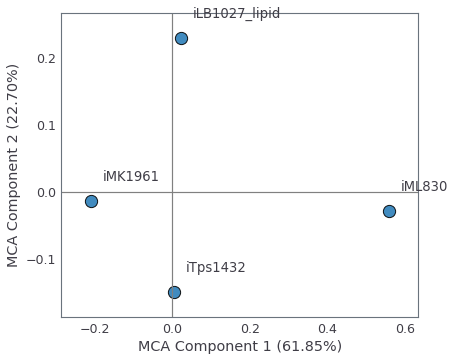

In [28]:
#Projections on the first 2 dimensions.
#%matplotlib inline
#import matplotlib.pyplot as plt

points = table3.loc[fs].values
#labels = table3.columns.values
labels = ['iLB1027_lipid', 'iMK1961', 'iTps1432', 'iML830']
plt.figure()
plt.margins(0.1)
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.xlabel('MCA Component 1 (61.85%)')
plt.ylabel('MCA Component 2 (22.70%)')

plt.scatter(*points, s=150, marker='o', c='#2c7fb8', alpha=.9, linewidths=1, edgecolor='black')
for label, x, y in zip(labels, *points):
    plt.annotate(label, xy=(x, y), xytext=(x + .03, y + .03))

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('rxns_mets_mca_18.05.svg')
plt.show()

# Comparing distribution of rxns among different pathways

In [124]:
# LOAD RXN DATA
df_rxns_no_comp = pd.read_csv('proceed_all_rxns_no_comp.txt', sep='\t', index_col=0)

In [29]:
# REMOVE THE DATA OF IRC MODEL
temp_list = list(df_rxns_no_comp.columns[df_rxns_no_comp.columns.str.contains('_subsystem')])
temp_list.remove('iRC1080_subsystem')
temp_list.remove('itHaps987_subsystem') 
df_subs = df_rxns_no_comp[temp_list]

In [30]:
# LOAD PATHWAY DICTIONARY
df_path = pd.read_csv('pathways_dict.txt', sep='\t', header=None)
df_path.columns = ['subs', 'path']
df_path = df_path.drop_duplicates(subset='subs', keep='last').reset_index(drop = True)


In [31]:
# MAP SUBSYSTEMS TO PATHWAYS
temp_list = list(df_subs.columns)
df_subs_path = []
for i, model in enumerate(temp_list):
    temp = df_subs[[model]].rename(columns={model:'subs'})
    temp1 = pd.merge(temp, df_path, on='subs', how='left')
    temp1 = temp1[temp1.subs.notna()]
    temp1['model'] = model
    if i==0:
        df_subs_path = temp1
    else:
        df_subs_path = pd.concat([df_subs_path, temp1])
    #df_subs_path.append(temp1)
df_subs_path.reset_index(drop=True,inplace=True)

In [32]:
def refine_path(source, target):    
    indx_temp = df_subs_path[df_subs_path.path == source].path.index
    df_subs_path.path.iloc[indx_temp] = target
    return df_subs_path

In [33]:
df_subs_path = refine_path(source='Urea cycle', target='Nitrogen metabolism')
df_subs_path = refine_path(source='Glycolysis / Gluconeogenesis', 
                           target='Carbohydrate metabolism')
df_subs_path = refine_path(source='TCA Cycle', 
                           target='Carbohydrate metabolism')
df_subs_path = refine_path(source='Pentose phosphate pathway', 
                           target='Carbohydrate metabolism')
df_subs_path = refine_path(source='Exchange', 
                           target='Exchange/Transport')
df_subs_path = refine_path(source='Transport', 
                           target='Exchange/Transport')

In [34]:
df_subs_path = df_subs_path[(df_subs_path.path != 'Not specified') &
(df_subs_path.path !='Biomass') &
(df_subs_path.path !='Xenobiotics biodegradation and metabolism')]

In [35]:
df_subs_path.sort_values(by='path', axis=0, inplace=True)

In [36]:
df_subs_path_count = df_subs_path.groupby(['model', 'path']).count().reset_index()

In [37]:
# TO CHANGE THE ORDER OF PATHWAYS AND KEEP CONSISTENT FOR EACH MODEL
temp_iMK1 = df_subs_path_count[df_subs_path_count.model=='iMK_draft17_subsystem'].reset_index(drop=True)
temp_iMK = df_subs_path_count[df_subs_path_count.model=='iMK_draft17_subsystem'].sort_values(by='subs',
                                                        ascending=False).reset_index(drop=True)

temp_iTps = df_subs_path_count[df_subs_path_count.model=='iTps1432_subsystem'].reset_index(drop=True)
temp_iTps['temp_imk'] = temp_iMK1.subs
temp_iTps = temp_iTps.sort_values(by='temp_imk', ascending=False)

temp_iLB = df_subs_path_count[df_subs_path_count.model=='iLB1027_lipid_subsystem'].reset_index(drop=True)
temp_iLB['temp_imk'] = temp_iMK1.subs
temp_iLB = temp_iLB.sort_values(by='temp_imk', ascending=False)

temp_iML = df_subs_path_count[df_subs_path_count.model=='Lavoie2020_subsystem'].reset_index(drop=True)
temp_iML['temp_imk'] = temp_iMK1.subs
temp_iML = temp_iML.sort_values(by='temp_imk', ascending=False)

In [38]:
temp_iMK.head(20)

,model,path,subs
0,iMK_draft17_subsystem,Lipid metabolism,4577
1,iMK_draft17_subsystem,Exchange/Transport,742
2,iMK_draft17_subsystem,Amino acid metabolism,436
3,iMK_draft17_subsystem,Carbohydrate metabolism,312
4,iMK_draft17_subsystem,Nucleotide metabolism,204
5,iMK_draft17_subsystem,Metabolism of cofactors and vitamins,202
6,iMK_draft17_subsystem,Energy metabolism,103
7,iMK_draft17_subsystem,Metabolism of terpenoids and polyketides,28
8,iMK_draft17_subsystem,Glycan biosynthesis and metabolism,23
9,iMK_draft17_subsystem,Nitrogen metabolism,15


/home/manish/anaconda2/envs/rstudio/lib/python3.7/site-packages/brokenaxes.py:294: UserWarning: FixedFormatter should only be used together with FixedLocator
  result.append(getattr(ax, method)(*args, **kwargs))


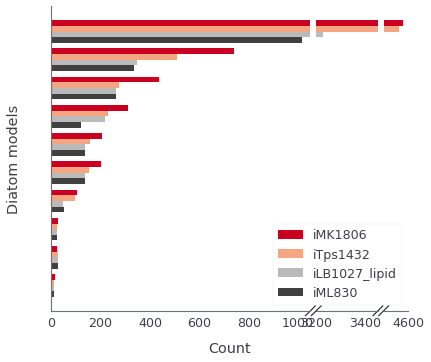

In [39]:

width = 0.2       # the width of the bars: can also be len(x) sequence
items = list(temp_iMK.path)
values_iMK = list(temp_iMK.subs)
values_iTps = list(temp_iTps.subs)
values_iLB = list(temp_iLB.subs)
values_iML = list(temp_iML.subs)

#print(values)
#change_values = [459, 316, 104]
#fig, ax = plt.subplots(figsize=(10,6))

#['#ca0020','#f4a582','#bababa','#404040']
x = np.arange(len(items))  # the label locations

ax = brokenaxes(xlims=((0, 1050), (3200, 3450), (4500, 4600)), 
                 #hspace=.05,
                 wspace=0.05
                )
ax.barh(x-width, values_iMK, width, label='iMK1806', color= '#ca0020')
ax.barh(x, values_iTps, width, label='iTps1432', color= '#f4a582')
ax.barh(x+width, values_iLB, width, label='iLB1027_lipid', color= '#bababa')
ax.barh(x+width*2, values_iML, width, label='iML830', color= '#404040')
#ax.barh(items, change_values, width, left=old_values,
           #label='Newly added', color= '#08519c')

ax.set_xlabel('Count')
ax.set_ylabel('Diatom models')
#ax.set_title('Comparison based on metabolites')
ax.legend(loc= 'lower right')

ax.set_yticks(np.arange(len(items)))
ax.set_yticklabels(items)
ax.invert_yaxis()
#plt.yticks(np.arange(len(items)),items)
    
plt.xticks(rotation=90)
ax.set_yticklabels([''])
#plt.figure(figsize=(2,2))
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('pathways_bar_18.05.svg')
plt.show()

# Size of four diatom genomes 

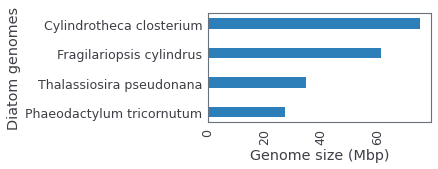

In [147]:
# PLOT GENOME SIZE OF DIATOMS
genome_size = [75.1, 61.1, 34.5, 27.4]
genome = ['Cylindrotheca closterium', 'Fragilariopsis cylindrus', 'Thalassiosira pseudonana',
         'Phaeodactylum tricornutum']
width=0.35
#df_mets_num=pd.DataFrame(genome_size, columns=['genome_size'])
#df_mets_num['genome'] = genome
#df_mets_num.sort_values(by='genome_size', inplace=True)
fig, ax = plt.subplots(figsize=(4,2))
ax.barh(genome,genome_size,width, color='#2c7fb8')
#sns.barplot(y='genome', x='genome_size', data=df_mets_num, color='#2c7fb8')
ax.invert_yaxis()
plt.xlabel('Genome size (Mbp)')
plt.ylabel('Diatom genomes')
plt.xticks(rotation=90)
    #, color='#fc8d62'
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('genome_size_comparison.svg')